In [96]:
import numpy as np
import math
import random

from scipy.stats import poisson, uniform

def truncated_Poisson(mu, maxval, sample_size):
    cutoff = poisson.cdf(maxval, mu)
    u = uniform.rvs(scale=cutoff, size=sample_size)
    truncated_poisson = poisson.ppf(u, mu)
    return truncated_poisson[0]

MC = 50
T = 100
N_L = 10000
N_H = 100
teta = 20
teta_min = 10
teta_max = 40
alpha_c = 0.04
sigma_c = 0.05
alpha_f = 0.04
sigma_f = 0.01
sigma_y = 0.01
delta = 0.0001
sigma_z = 0.01
zeta = 1
gamma_L = 5 # 20
gamma_H = 2 # 20
eta_min = 0
eta_max = 0.2
lambda_m = 0.625
kappa_min = 0
kappa_max = 0.01

N_stocks = 100000
LF_ratio = 0.9
HF_ratio = 1 - LF_ratio
ipo_price = 100

In [97]:
class PersonLF:
    def __init__(self, strategy, n_stocks):
        self.strategy = strategy
        self.fulfilled = [(ipo_price, n_stocks)]
        self.profit = 0
        self.stocks = n_stocks

class Order:
    def __init__(self, time, size, person):
        self.time = time
        self.size = size
        self.person = person

class PersonHF:
    def __init__(self, strategy, n_stocks):
        self.strategy = strategy
        self.fulfilled = [(ipo_price, n_stocks)]
        self.stocks = n_stocks
        self.profit = 0

LFTraders = []
HFTraders = []

def GetUniformValue(low, high, size = 1):
    if size == 1:
        return np.random.uniform(low, high, size)[0]
    return np.random.uniform(low, high, size)

for i in range(N_L):
    LFTraders.append(PersonLF(random.randint(0, 1), N_stocks*LF_ratio//N_L))
for i in range(N_H):
    HFTraders.append(PersonHF(GetUniformValue(eta_min, eta_max, 1), N_stocks*HF_ratio//N_H))

def GetNormalError(mean, std):
    return np.random.normal(mean, std)

def OrdersChartist(alpha_c, P_1, P_2):
    quant = alpha_c*(P_1 - P_2) + GetNormalError(0, sigma_c)
    if quant > 0:
        return math.ceil(quant)
    return 0

def GetProfit(P_m, P_p, Orders):
    return (P_m - P_p)*Orders

def ChartistProbabilityLF(profit_c, profit_f):
    return math.exp(profit_c/zeta)/(math.exp(profit_c/zeta) + math.exp(profit_f/zeta))

def FundamentProbabilityLF(profit_c, profit_f):
    return 1 - ChartistProbabilityLF(profit_c, profit_f)
  
def WillTradeHF(p_1, p_2, thresh):
    return abs((p_1 - p_2)/p_2) > thresh

def OrdersFundamental(F_t, P_1):
    quant = alpha_f*(F_t - P_1) + GetNormalError(0, sigma_f)
    if quant > 0:
        return math.ceil(quant)
    return 0

def FundamentalValueOfTheAsset(prev):
    return round(prev * (1 + delta) * (1 + GetNormalError(0, sigma_y)), 1)

def LimitAsk(bestAsk):
  return round(bestAsk*(1+GetUniformValue(kappa_min, kappa_max)), 1)

def LimitBid(bestBid):
  return round(bestBid*(1-GetUniformValue(kappa_min, kappa_max)), 1)

def LimitOrderPrice(P_1):
  return round(P_1*(1+delta)*(1+GetNormalError(0,sigma_z)), 1)

def UpdateCup(cupPerson, orderSize, person, orderPrice, time):
    ord = Order(time, orderSize, person)
    if cupPerson.get(orderPrice):
        cupPerson[orderPrice] += [ord]
    else:
        cupPerson[orderPrice] = [ord]

def fulfillBuyOrder(person, size, price):
    person.stocks += size
    person.fulfilled.append((price, size))

def fulfillSellOrder(person, size, price):
    person.stocks -= size

def fulfillBuyOrdersAtPrice(price, orders):
    for order in orders:
        fulfillBuyOrder(order.person, order.size, price)

def fulfillSellOrdersAtPrice(price, orders):
    for order in orders:
        fulfillSellOrder(order.person, order.size, price)

def partiallyFulfillBuyOrdersAtPrice(price, orders, size, bidPrice):
    global cupBidPerson

    fulfilled = 0
    for order in orders:
        if order.size <= size - fulfilled:
            fulfillBuyOrder(order.person, order.size, price)
            fulfilled += order.size
            cupBidPerson[bidPrice].remove(order)
        else:
            # Close by remaining size
            order.person.stocks += size - fulfilled
            order.person.fulfilled.append((price, size - fulfilled))
            next(ord for ord in cupBidPerson[bidPrice] if order == ord).size -= size - fulfilled
            return

def partiallyFulfillSellOrdersAtPrice(price, orders, size, askPrice):
    global cupAskPerson

    fulfilled = 0
    for order in orders:
        if order.size <= size - fulfilled:
            fulfillSellOrder(order.person, order.size, price)
            fulfilled += order.size
            cupAskPerson[askPrice].remove(order)
        else:
            # Close by remaining size
            order.person.stocks -= size - fulfilled
            order.person.fulfilled.append((price, size - fulfilled))
            next(ord for ord in cupAskPerson[askPrice] if order == ord).size -= size - fulfilled
            return

def balanceCup(cupAskPerson, cupBidPerson):
    asks = list(getOrderSizeCup(cupAskPerson).keys())
    bids = list(getOrderSizeCup(cupBidPerson).keys())
    if len(asks) == 0 or len(bids) == 0:
        return
    while min(asks) <= max(bids):
        cupAsk = getOrderSizeCup(cupAskPerson)
        cupBid = getOrderSizeCup(cupBidPerson)
        
        if cupAsk[min(asks)] < cupBid[max(bids)]:
            # cupBid[max(bids)] -= cupAsk[min(asks)]
            avgPrice = (min(asks) + max(bids)) / 2
            fulfillSellOrdersAtPrice(avgPrice, cupAskPerson[min(asks)])
            partiallyFulfillBuyOrdersAtPrice(avgPrice, cupBidPerson[max(bids)], cupAsk[min(asks)], max(bids))
            del cupAskPerson[min(asks)]
            asks.remove(min(asks))
            
        elif cupAsk[min(asks)] > cupBid[max(bids)]:
            # cupAsk[min(asks)] -= cupBid[max(bids)]
            avgPrice = (min(asks) + max(bids)) / 2
            fulfillBuyOrdersAtPrice(avgPrice, cupBidPerson[max(bids)])
            partiallyFulfillSellOrdersAtPrice(avgPrice, cupAskPerson[min(asks)], cupBid[max(bids)], min(asks))
            del cupBidPerson[max(bids)]
            bids.remove(max(bids))

        else:
            avgPrice = (min(asks) + max(bids)) / 2
            fulfillBuyOrdersAtPrice(avgPrice, cupBidPerson[max(bids)])
            fulfillSellOrdersAtPrice(avgPrice, cupAskPerson[min(asks)])
            del cupBidPerson[max(bids)]
            bids.remove(max(bids))
            del cupAskPerson[min(asks)]
            asks.remove(min(asks))
        if len(asks) == 0 or len(bids) == 0:
            return
            
def getOrderSizeCup(cupPerson: dict) -> dict:
    result = {}
    for (k, v) in cupPerson.items():
        s = 0
        for i in v:
            s += i.size
        result[k] = s
    return result

def CurrentMarketPrice(cupAskPerson, cupBidPerson):
    cupAsk = getOrderSizeCup(cupAskPerson).keys()
    cupBid = getOrderSizeCup(cupBidPerson).keys()
    if len(cupAsk) != 0 and len(cupBid) != 0:
        return (min(cupAsk) + max(cupBid))/2
    if len(cupAsk) == 0 and len(cupBid) != 0:
        return (priceMarket[-1] + max(cupBid))/2
    elif len(cupBid) == 0 and len(cupAsk) != 0:
        return (min(cupAsk) + priceMarket[-1])/2
    return priceMarket[-1]

def removeOld(cupAskPerson, cupBidPerson, currentDay):
    cupAskN = {}
    cupBidN = {}
    for price, orders in cupAskPerson.items():
        cupAskN[price] = []
        for order in orders:
            if (abs(order.time - currentDay) > gamma_L) and (isinstance(order.person, PersonLF)):
                order.person.stocks += order.size
                continue
            elif (abs(order.time - currentDay) > gamma_H) and (isinstance(order.person, PersonHF)):
                order.person.stocks += order.size
                continue
            cupAskN[price].append(order)
        if len(cupAskN[price]) == 0:
            del cupAskN[price]

    for price, orders in cupBidPerson.items():
        cupBidN[price] = []
        for order in orders:
            if (abs(order.time - currentDay) > gamma_L) and (isinstance(order.person, PersonLF)):
                continue
            if (abs(order.time - currentDay) > gamma_H) and (isinstance(order.person, PersonHF)):
                continue
            cupBidN[price].append(order)
        if len(cupBidN[price]) == 0:
            del cupBidN[price]
    return cupAskN, cupBidN

In [98]:
priceFundamental = [100.00]
for i in range(1, T+50):
    priceFundamental.append(FundamentalValueOfTheAsset(priceFundamental[-1]))

priceMarket = [ipo_price, FundamentalValueOfTheAsset(100)]

cupAskPerson = {}
cupBidPerson = {}

for current_day in range(T):
    cupAskPerson, cupBidPerson = removeOld(cupAskPerson, cupBidPerson, current_day)
    for person in LFTraders:
        cur_price = priceMarket[-1]
        if person.strategy == 1:
            orderPrice = LimitOrderPrice(priceMarket[-1])
            orderSize = OrdersFundamental(priceFundamental[current_day+1], priceMarket[-1])
            if orderSize == 0:
                continue
            if orderPrice >= cur_price:
                if person.stocks < orderSize:
                    orderSize = person.stocks
                UpdateCup(cupAskPerson, orderSize, person, orderPrice, current_day)
                person.stocks -= orderSize
            else:
                UpdateCup(cupBidPerson, orderSize, person, orderPrice, current_day)
        elif current_day > 2:
            orderPrice = LimitOrderPrice(priceMarket[-1])
            orderSize = OrdersChartist(alpha_c, priceMarket[-1], priceMarket[-2])
            if orderSize == 0:
                continue
            if orderPrice >= cur_price:
                if person.stocks < orderSize:
                    orderSize = person.stocks
                UpdateCup(cupAskPerson, orderSize, person, orderPrice, current_day)
                person.stocks -= orderSize
            else:
                UpdateCup(cupBidPerson, orderSize, person, orderPrice, current_day)


    for person in HFTraders:
        if WillTradeHF(priceMarket[-1], priceMarket[-2], person.strategy):
            buy = random.randint(0, 1)
            cupBid = getOrderSizeCup(cupBidPerson)
            cupAsk = getOrderSizeCup(cupAskPerson)
            if buy == 1:
                orderSize = math.ceil(truncated_Poisson(sum(cupAsk.values())*lambda_m, sum(cupAsk.values())/4, 1))
                if person.stocks < orderSize:
                    orderSize = person.stocks
                try:
                    orderPrice = LimitAsk(list(cupAsk.keys())[-1])
                except:
                    orderPrice = LimitAsk(priceMarket[-1])
                UpdateCup(cupBidPerson, orderSize, person, orderPrice, current_day)
                person.stocks -= orderSize
            else:
                orderSize = math.ceil(truncated_Poisson(sum(cupBid.values())*lambda_m, sum(cupBid.values())/4, 1))
                if person.stocks < orderSize:
                    orderSize = person.stocks
                try:
                    orderPrice = LimitBid(list(cupBid.keys())[-1])
                except:
                    orderPrice = LimitBid(priceMarket[-1])
                UpdateCup(cupAskPerson, orderSize, person, orderPrice, current_day)
                person.stocks -= orderSize

    cupAsk = dict(sorted(getOrderSizeCup(cupAskPerson).items(), reverse=True))
    cupBid = dict(sorted(getOrderSizeCup(cupBidPerson).items(), reverse=True))
    balanceCup(cupAskPerson, cupBidPerson)
    newPrice = round(CurrentMarketPrice(cupAskPerson, cupBidPerson),2)
    priceMarket.append(newPrice)
    # print(newPrice)

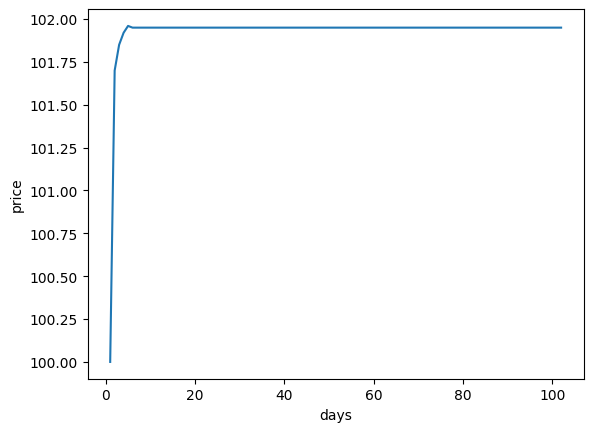

In [99]:
import matplotlib.pyplot as plt
_ = plt.plot(list(range(1, T+3)), priceMarket)
_ = plt.xlabel('days')
_ = plt.ylabel('price')

In [100]:
cupBid = dict(sorted(getOrderSizeCup(cupBidPerson).items(), reverse=True))
cupBid

{101.9: 896,
 101.8: 894,
 101.7: 865,
 101.6: 811,
 101.5: 782,
 101.4: 776,
 101.3: 752,
 101.2: 669,
 101.1: 640,
 101.0: 577,
 100.9: 509,
 100.8: 417,
 100.7: 400,
 100.6: 374,
 100.5: 345,
 100.4: 280,
 100.3: 217,
 100.2: 202,
 100.1: 186,
 100.0: 135,
 99.9: 104,
 99.8: 80,
 99.7: 69,
 99.6: 60,
 99.5: 42,
 99.4: 49,
 99.3: 37,
 99.2: 28,
 99.1: 10,
 99.0: 19,
 98.9: 14,
 98.8: 6,
 98.7: 2,
 98.6: 3,
 98.5: 1,
 98.4: 2,
 98.3: 3,
 98.2: 1}